Ansatz inspiriert von Paper: Macroeconomic forecasting in times of crises 
Download: file:///C:/Users/Maria/Downloads/J%20of%20Applied%20Econometrics%20-%202022%20-%20Guerr%C3%B3on%E2%80%90Quintana%20-%20Macroeconomic%20forecasting%20in%20times%20of%20crises%20(2).pdf

1. Schritt: ARMA Modell für DAX Returns

In [1]:
import pandas as pd
import numpy as np

import pmdarima
import statsmodels as sm

from dax.help_functions.get_dax_data import get_prepared_data

In [2]:
daxdata = get_prepared_data()
daxdata

,Close,LogRetLag1,LogRetLag2,LogRetLag3,LogRetLag4,LogRetLag5
Date,,,,,,
2019-09-10 00:00:00+02:00,12268.709961,0.347914,0.629422,1.163586,2.006097,2.960150
2019-09-11 00:00:00+02:00,12359.070312,0.733812,1.081725,1.363234,1.897398,2.739909
2019-09-12 00:00:00+02:00,12410.250000,0.413251,1.147063,1.494977,1.776485,2.310649
2019-09-13 00:00:00+02:00,12468.530273,0.468515,0.881766,1.615578,1.963491,2.245000
2019-09-16 00:00:00+02:00,12380.309570,-0.710062,-0.241547,0.171704,0.905516,1.253429
...,...,...,...,...,...,...
2024-01-18 00:00:00+01:00,16567.349609,0.822211,-0.026133,-0.330653,-0.824790,0.122728
2024-01-19 00:00:00+01:00,16555.130859,-0.073779,0.748432,-0.099912,-0.404432,-0.898569
2024-01-22 00:00:00+01:00,16683.359375,0.771570,0.697791,1.520002,0.671658,0.367138


In [3]:
order_dict_bic = {}
for h in ['LogRetLag1', 'LogRetLag2', 'LogRetLag3', 'LogRetLag4', 'LogRetLag5']:
    # fit ARIMA on returns, use bic since paper uses bic too
    arima_model_fitted = pmdarima.auto_arima(daxdata[h], stationary=True, information_criterion='bic')
    order_dict_bic.update({h: arima_model_fitted.order})

order_dict_bic

{'LogRetLag1': (0, 0, 0),
 'LogRetLag2': (5, 0, 0),
 'LogRetLag3': (5, 0, 1),
 'LogRetLag4': (1, 0, 0),
 'LogRetLag5': (5, 0, 2)}

For the beginning: Solely consider LogRetLag1 
OPtimal order is (0,0,0) --> estimated log ret always 0 

In [5]:
# fit model 
from statsmodels.tsa.arima.model import ARIMA
import warnings
# Suppress the specific warning
warnings.filterwarnings(
    "ignore", message="An unsupported index was provided and will be ignored", category=UserWarning)
warnings.filterwarnings(
    "ignore", message="A date index has been provided, but it has no associated frequency information", category=UserWarning)

model = ARIMA(daxdata['LogRetLag1'], order=(0, 0, 0))
model_fit = model.fit()
residuals = model_fit.resid
residuals

Date
2019-09-10 00:00:00+02:00    0.319728
2019-09-11 00:00:00+02:00    0.705626
2019-09-12 00:00:00+02:00    0.385066
2019-09-13 00:00:00+02:00    0.440329
2019-09-16 00:00:00+02:00   -0.738248
                               ...   
2024-01-04 00:00:00+01:00    0.447742
2024-01-05 00:00:00+01:00   -0.167162
2024-01-08 00:00:00+01:00    0.705875
2024-01-09 00:00:00+01:00   -0.196493
2024-01-10 00:00:00+01:00   -0.019490
Length: 1104, dtype: float64

In [6]:
def calculate_distance(daxdata, h, j, k): 
   
    # fixed parameters
    weight_vector = np.array([1/(k-i+1) for i in range(1, k+1)])
    last_k_obs = np.array(daxdata[f'LogRetLag{h}'].iloc[-k:])

    # get obs window
    starting_index = j-k+1
    obs_window = np.array(
        daxdata[starting_index:starting_index+k][f'LogRetLag{h}'])

    # calculate distance 
    dist = np.sum(weight_vector*((last_k_obs-obs_window)**2))

    return dist

def calculate_mean_residuals(daxdata, j_min, k): 
    starting_index = j_min-k+1
    residuals = np.array(
        daxdata[starting_index:starting_index+k]['residuals'])
    
    # calculate mean
    mean_residuals = np.mean(residuals)

    return mean_residuals
    

In [16]:
warnings.filterwarnings(
    "ignore", message="No supported index is available. Prediction results will be given with an integer index beginning at `start`.", category=UserWarning)
warnings.filterwarnings(
    "ignore", message="No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.", category=FutureWarning)
warnings.filterwarnings(
    "ignore", message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.", category=UserWarning)
warnings.filterwarnings(
    "ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.", category=UserWarning)

In [22]:
import math
from scipy.stats import norm, t
def get_norm_quantiles_mean(mean, variance):
    corrected_means = np.array(corrected_means)
    variances = np.array(variances)
    norm_quantiles = norm.ppf([0.025, 0.25, 0.5, 0.75, 0.975])
    corrected_means + variances*norm_quantiles

In [ ]:
from evaluation.help_functions.prepare_data import next_working_days
from dax.models.ARMA_GARCH.get_quantiles import get_norm_quantiles_mean

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
# get data 
daxdata = get_prepared_data()
daxdata = daxdata.reset_index()

# try out fix parameter
k = 10
m = 5
horizons = [1, 2, 3, 4, 5]

# store arima means in dict 
arima_means = {}

# store forecast corrections in dict
forecast_correction = {}

# optimal orders based on bic
opt_orders = {
    1: (0, 0, 0),
    2: (5, 0, 0),
    3: (5, 0, 1),
    4: (1, 0, 0),
    5: (5, 0, 2)
}

# store corrected means and residual variance in list 
corrected_means = []
variances = []

for h in horizons:

    # estimate mean with ARIMA 
    model = ARIMA(daxdata[[f'LogRetLag{h}']], order= opt_orders[h])
    model_fit = model.fit()
    model_residuals = model_fit.resid
    variances.append(np.var(model_residuals))

    # get col index of  observed Log Return
    ci_logret = daxdata.columns.get_loc(f'LogRetLag{h}')

    # forecast desired horizon
    mi = daxdata.index.max()
    arima_mean = model_fit.predict(start=mi+1, end=mi+6).iloc[(h-1)]  
    arima_means.update({h: arima_mean})

    print(f"-----start of horizon {h} -----------")

    # calculate distances for return
    daxdata[f'distance_{h}'] = np.nan
    starting_index = daxdata.index.min() + k

    # get col index 
    ci = daxdata.columns.get_loc(f'distance_{h}')

    for j in range(k, len(daxdata)):
        daxdata.iat[j, ci] = calculate_distance(daxdata, h, j, k)
    daxdata = daxdata.dropna(subset=[f'distance_{h}'])

    # set last value (zero distance) high enough so that index does not get chosen
    daxdata.iat[len(daxdata)-1, ci] = 10

    # top m matching parts
    top_indices = daxdata[f'distance_{h}'].nsmallest(m).index

    # iterate over top m matching parts, estimate prediction and store residual 
    
    residuals = []
    for ti in top_indices: 

        print( '------ start of new part ----------')

        if (ti < len(daxdata)-h):

            # train model with all data up to ti
            model = ARIMA(daxdata[[f'LogRetLag{h}']][:ti+1], order= opt_orders[h])
            model_fit = model.fit()

            # get col index of  observed Log Return
            ci_logret = daxdata.columns.get_loc(f'LogRetLag{h}')

            # calculate residual for desired horizon
            yhat = model_fit.predict(start=ti+1, end=ti+6).iloc[(h-1)]  
            yobs = daxdata.iat[ti+h-1, ci_logret]
            residual = yobs - yhat

            # append to list of residuals 
            residuals.append(residual)
    
    forecast_correction.update({h: np.mean(np.array(residuals))})
    
    # calculate corrected mean
    corrected_means.append(arima_means[h]-forecast_correction[h])

# get quantiles
column_names = [f'q{q}' for q in quantiles]
daxdata = daxdata.set_index("Date")
start_date_dates = max(daxdata.index).strftime('%Y-%m-%d')
dates = next_working_days(start_date_dates, 5)
quantile_df = pd.DataFrame(index=dates, columns=column_names)

# calculate forecasting quantiles
for h in range(0, 5):

    mean = corrected_means[h]
    variance = variances[h]

    for q in quantiles:
        quantile_q = mean + variance*norm.ppf(q)
        quantile_df.loc[dates[h]][f'q{q}'] = quantile_q
        

In [121]:
top_indices
#h1 --> 0 
#daxdata.iloc[top_indices]
top_indices


Index([1044, 878, 972, 779, 452], dtype='int64')

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm

from dax.help_functions.get_dax_data import get_prepared_data
from evaluation.help_functions.prepare_data import next_working_days
from dax.models.ARMA_NN.distance import calculate_distance

# Suppress warnings
# Note: I always checked that results fit (iterative testing, thereby, warnings can be ignored for now)
warnings.filterwarnings(
    "ignore", message="An unsupported index was provided and will be ignored", category=UserWarning)
warnings.filterwarnings(
    "ignore", message="A date index has been provided, but it has no associated frequency information", category=UserWarning)
warnings.filterwarnings(
    "ignore", message="No supported index is available. Prediction results will be given with an integer index beginning at `start`.", category=UserWarning)
warnings.filterwarnings(
    "ignore", message="No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.", category=FutureWarning)
warnings.filterwarnings(
    "ignore", message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.", category=UserWarning)
warnings.filterwarnings(
    "ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.", category=UserWarning)

# optimal ARIMA order based on bic
opt_orders = {
    1: (0, 0, 0),
    2: (5, 0, 0),
    3: (5, 0, 1),
    4: (1, 0, 0),
    5: (5, 0, 2)
}

# adjust parameters if needed
k = 10
m = 9


def get_arma_nn_forecasts(daxdata=pd.DataFrame(), quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], submission=True):

    if daxdata.empty:
        daxdata = get_prepared_data()
    daxdata = daxdata.reset_index()

    horizons = [1, 2, 3, 4, 5]

    # store arima means in dict
    arima_means = {}

    # store forecast corrections in dict
    forecast_correction = {}

    # store corrected means and residual variance in list
    corrected_means = []
    variances = []

    for h in horizons:

        # estimate mean with ARIMA
        model = ARIMA(daxdata[[f'LogRetLag{h}']], order=opt_orders[h])
        model_fit = model.fit()
        model_residuals = model_fit.resid
        variances.append(np.var(model_residuals))

        # get col index of  observed Log Return
        ci_logret = daxdata.columns.get_loc(f'LogRetLag{h}')

        # forecast desired horizon
        mi = daxdata.index.max()
        arima_mean = model_fit.predict(start=mi+1, end=mi+6).iloc[(h-1)]
        arima_means.update({h: arima_mean})

        # calculate distances for return
        daxdata[f'distance_{h}'] = np.nan
        starting_index = daxdata.index.min() + k

        # get col index
        ci = daxdata.columns.get_loc(f'distance_{h}')

        for j in range(k, len(daxdata)):
            daxdata.iat[j, ci] = calculate_distance(daxdata, h, j, k)
        daxdata = daxdata.dropna(subset=[f'distance_{h}'])

        # set last value (zero distance) high enough so that index does not get chosen
        daxdata.iat[len(daxdata)-1, ci] = 10

        # top m matching parts
        top_indices = daxdata[f'distance_{h}'].nsmallest(m).index

        # iterate over top m matching parts, estimate prediction and store residual
        residuals = []
        for ti in top_indices:

            if (ti < len(daxdata)-h):

                # train model with all data up to ti
                model = ARIMA(
                    daxdata[[f'LogRetLag{h}']][:ti+1], order=opt_orders[h])
                model_fit = model.fit()

                # get col index of  observed Log Return
                ci_logret = daxdata.columns.get_loc(f'LogRetLag{h}')

                # calculate residual for desired horizon
                yhat = model_fit.predict(start=ti+1, end=ti+6).iloc[(h-1)]
                yobs = daxdata.iat[ti+h-1, ci_logret]
                residual = yobs - yhat

                # append to list of residuals
                residuals.append(residual)

        forecast_correction.update({h: np.mean(np.array(residuals))})

        # calculate corrected mean
        corrected_means.append(arima_means[h]-forecast_correction[h])

    # get quantiles
    column_names = [f'q{q}' for q in quantiles]
    daxdata = daxdata.set_index("Date")
    start_date_dates = max(daxdata.index).strftime('%Y-%m-%d')
    dates = next_working_days(start_date_dates, 5)
    quantile_df = pd.DataFrame(index=dates, columns=column_names)

    # calculate prediction quantiles
    for h in range(0, 5):

        mean = corrected_means[h]
        variance = variances[h]

        for q in quantiles:
            quantile_q = mean + variance*norm.ppf(q)
            quantile_df.loc[dates[h]][f'q{q}'] = quantile_q

    if submission == True:
        date_st = daxdata.index[-1].strftime('%Y-%m-%d')
        quantile_df.insert(0, 'forecast_date', date_st)
        quantile_df.insert(1, 'target', 'DAX')
        quantile_df.insert(
            2, "horizon", [str(i) + " day" for i in (1, 2, 5, 6, 7)])
        quantile_df.index.name = "date_time"

    return quantile_df


warnings.resetwarnings()

In [4]:
daxdata = get_prepared_data()

In [5]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'return'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# exactly 8 weekly rounds from energydata_hist to new data
for i in range(1, 20):
    print(f'start of round {i}')
    forecasts = get_arma_nn_forecasts(daxdata[:i*(-5)],
                                          quantiles=quantiles, submission=False).reset_index()
    obs = []
    for h in [1, 2, 3, 4, 5]:
        obs.append(daxdata[-5*i:].iat[h-1, h])
    forecasts['return'] = obs

    pit_merged = pd.concat([pit_merged, forecasts])

start of round 1


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 2


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 3


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 4


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 5


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 6


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 7


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 8


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 9


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 10


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 11


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 12


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 13


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 14


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 15


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 16


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 17


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 18


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

start of round 19


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmo

In [6]:
import matplotlib.pyplot as plt
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))


def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['return'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
ordered_quantile_counts

{0.1: 0,
 0.2: 3,
 0.3: 9,
 0.4: 19,
 0.5: 17,
 0.6: 15,
 0.7: 14,
 0.8: 15,
 0.9: 2,
 1: 1}

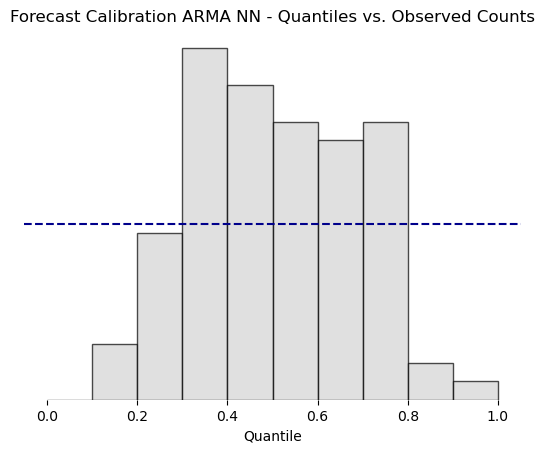

In [8]:
import matplotlib.pyplot as plt

bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate the mean of the y-values
mean_value = sum(counts) / len(counts)

# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])

# Plot mean
plt.axhline(y=mean_value, color='darkblue', linestyle='--', label='Mean')


# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration ARMA NN - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()